In [1]:
using Pkg
Pkg.activate("../OldEnvironment")

  Activating project at `~/PhD/GaussianProcessNode/OldEnvironment`


In [2]:
using ApproximateGPs
using Distributions, LinearAlgebra, StatsFuns
using PDMats: PDMat
using IterTools: ncycle
using Flux
using Plots
using JLD, MAT 

## Useful function

In [3]:
# standardized mean squared error (for regression)
function SMSE(y_true, y_approx)
    N = length(y_true)
    mse = norm(y_true - y_approx)^2 / N 
    return mse / var(y_true)
end

SMSE (generic function with 1 method)

## Toy dataset 

In [4]:
#load data 
data_path = "../savefiles/" 
xtrain = load(data_path*"xtrain_toyregression.jld")["xtrain"]
ytrain = load(data_path*"ytrain_toyregression.jld")["ytrain"]

xtest = load(data_path*"xtest_toyregression.jld")["xtest"]
ytest = load(data_path*"ytest_toyregression.jld")["ytest"]

Xu = collect(load(data_path*"Xu_toyregression.jld")["Xu"]);
M = length(Xu);
N = length(ytrain);

In [5]:
function make_kernel(k_params)
    variance = StatsFuns.softplus(k_params[1])
    lengthscale = StatsFuns.softplus(k_params[2])
    return variance * with_lengthscale(SqExponentialKernel(), lengthscale)
end

init_variance = 1.
init_lengthscale = 1.
k_init = [StatsFuns.invsoftplus(init_variance), StatsFuns.invsoftplus(init_lengthscale)];

In [6]:
struct SVGPModel
    k  :: Vector{Float64}     # kernel parameters
    m  :: Vector{Float64}   # variational mean
    A  :: Matrix{Float64}     # square-root of variational covariance
end

Flux.@functor SVGPModel (k, m, A);

In [7]:
lik_noise = 0.01
jitter = 1e-5;
function prior(m::SVGPModel)
    kernel = make_kernel(m.k)
    return GP(kernel)
end
function make_approx(m::SVGPModel, prior)
    # Efficiently constructs S as A*Aᵀ
    S = PDMat(Cholesky(LowerTriangular(m.A)))
    q = MvNormal(m.m, S)
    fz = prior(Xu, jitter)
    return SparseVariationalApproximation(fz, q)
end;
function model_posterior(m::SVGPModel)
    svgp = make_approx(m, prior(m))
    return posterior(svgp)
end;

function (m::SVGPModel)(x)
    post = model_posterior(m)
    return post(x)
end;

function loss(m::SVGPModel, x, y; num_data=length(ytrain))
    f = prior(m)
    fx = f(x, lik_noise)
    svgp = make_approx(m, f)
    return -elbo(svgp, fx, y; num_data)
end;

In [8]:
m_init = zeros(M)
A_init = Matrix{Float64}(I, M, M)

model = SVGPModel(k_init, m_init, A_init);
opt = AdaMax()  # Define the optimiser
params_toy = Flux.params(model);  # Extract the model parameters

In [9]:
data_loader = Flux.DataLoader((xtrain, ytrain);batchsize=N)
loss_val = []
callback = function ()
    append!(loss_val,loss(model,xtrain,ytrain))
end
Flux.train!(
    (x, y) -> loss(model, x, y; num_data=N),
    params_toy,
    ncycle(data_loader, 5000), 
    opt;
    cb = callback
);

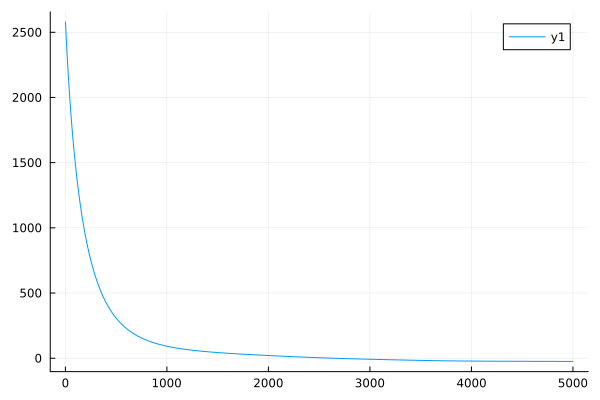

In [10]:
plot(loss_val)

In [11]:
post = model_posterior(model)
my_predict = post(xtest);

In [12]:
println("SMSE value of VSGP ", SMSE(ytest, mean(my_predict)))

SMSE value of VSGP 0.00461536448805206


## kin40k dataset

In [13]:
xtrain_kin40 = matopen("../data/kin40k/kin40k_xtrain.mat");
xtest_kin40 = matopen("../data/kin40k/kin40k_xtest.mat");
ytrain_kin40 = matopen("../data/kin40k/kin40k_ytrain.mat");
ytest_kin40 = matopen("../data/kin40k/kin40k_ytest.mat");

xtrain_kin40 = read(xtrain_kin40, "xtrain") #|> (x) -> Matrix(x');
ytrain_kin40 = read(ytrain_kin40, "ytrain") |> (x) -> vcat(x...);
xtest_kin40 = read(xtest_kin40, "xtest") #|> (x) -> Matrix(x');
ytest_kin40 = read(ytest_kin40, "ytest") |> (x) -> vcat(x...);

Ntrain = length(ytrain_kin40);
xtrain_kin40 = [xtrain_kin40[i,:] for i=1:Ntrain];
data_training = (xtrain_kin40, ytrain_kin40);

Ntest = length(ytest_kin40);
xtest_kin40 = [xtest_kin40[i,:] for i=1:Ntest];
Xu_kin40k = load(data_path*"Xu_kin40k.jld")["Xu"] #|> (x) -> hcat(x...);
M_kin40k = length(Xu_kin40k);
N_kin40k = length(ytrain_kin40)

10000

In [14]:
function make_kernel_kin40k(k_params)
    variance = StatsFuns.softplus(k_params[1])
    lengthscale = StatsFuns.softplus.(k_params[2:end])
    return variance * with_lengthscale(SqExponentialKernel(), lengthscale)
end

init_variance = 1
init_lengthscale = ones(8)
k_kin40k_init = [StatsFuns.invsoftplus(init_variance), StatsFuns.invsoftplus.(init_lengthscale)] |> (x) -> vcat(x...);

In [15]:
lik_noise = 0.01
jitter = 1e-5;
function prior_kin40k(m::SVGPModel)
    kernel = make_kernel_kin40k(m.k)
    return GP(kernel)
end
function make_approx_kin40k(m::SVGPModel, prior)
    # Efficiently constructs S as A*Aᵀ
    S = PDMat(Cholesky(LowerTriangular(m.A)))
    q = MvNormal(m.m, S)
    fz = prior(Xu_kin40k, jitter)
    return SparseVariationalApproximation(fz, q)
end;
function model_posterior_kin40k(m::SVGPModel)
    svgp = make_approx_kin40k(m, prior_kin40k(m))
    return posterior(svgp)
end;

function (m::SVGPModel)(x)
    post = model_posterior_kin40k(m)
    return post(x)
end;

function loss(m::SVGPModel, x, y, liknoise; num_data=length(ytrain_kin40))
    f = prior_kin40k(m)
    fx = f(x, liknoise)
    svgp = make_approx_kin40k(m, f)
    return -elbo(svgp, fx, y; num_data)
end;

In [9]:
m_kin40k_init = zeros(M_kin40k)
A_kin40k_init = Matrix{Float64}(I, M_kin40k, M_kin40k)

model_kin40k = SVGPModel(k_kin40k_init, m_kin40k_init, A_kin40k_init);
opt = AdaMax()  # Define the optimiser
params_kin40k = Flux.params(model_kin40k);  # Extract the model parameters

In [ ]:
b = 500 #batch size
data_loader = Flux.DataLoader((xtrain_kin40, ytrain_kin40);batchsize=b)
loss_val_kin40k = []
call_back = function ()
    append!(loss_val_kin40k,loss(model_kin40k,xtrain_kin40,ytrain_kin40,lik_noise))
end
Flux.train!(
    (x, y) -> loss(model_kin40k, x, y,lik_noise; num_data=N_kin40k),
    Flux.params(model_kin40k),
    ncycle(data_loader,2200), # Train for 2200 epochs, take ≈5h, 15 min for 100 epoch
    opt,
);

## Training record for -elbo:
    # 1000 epochs: 36338.973091799664
    # 1100 epochs: 35502.4886019628
    # 1200 epochs: 34815.820298233666
    # 1500 epochs: 33330.614025145114
    # 1600 epochs: 32964.23673036584
    # 2000 epochs: 31874.648275920816
    # 2100 epochs: 31668.691955870792
    # 2200 epochs: 31481.76970349619

In [50]:
post_kin40k = model_posterior_kin40k(model_kin40k)
my_predict_kin40k = post_kin40k(xtest_kin40);

In [53]:
println("SMSE value of VSGP ", SMSE(ytest_kin40, mean(my_predict_kin40k)))

SMSE value of VSGP 0.08747797670691111


In [52]:
save("../savefiles/VSGP_model_kin40k.jld","model",model_kin40k)
save("../savefiles/VSGP_posterior_kin40k.jld","posterior",post_kin40k)